<a href="https://colab.research.google.com/github/SofiaE24/Anomaly-Detection/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install tslearn
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190292 sha256=3245b14dddad0a5b765da545f21592dd81d5fd5da45645345f9a4788356cc880
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt  # data plotting
from matplotlib import pyplot
from matplotlib import rcParams
import matplotlib.colors as mcolors

# Set matplotlib parameters for plotting
rcParams['figure.figsize'] = 11.7, 8.27  # A4 format - [inches]
rcParams['lines.markersize'] = 6  # marker size in points
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

# Import libraries for time series clustering and anomaly detection
from tslearn.clustering import TimeSeriesKMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Import additional libraries for time series analysis and visualization
from statsmodels.tsa.seasonal import STL
from pyod.models.lof import LOF
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

In [3]:
# Download and unzip a dataset from the European Central Bank
!wget https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist.zip
!unzip eurofxref-hist.zip

--2023-12-06 15:26:46--  https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist.zip
Resolving www.ecb.europa.eu (www.ecb.europa.eu)... 80.90.16.91
Connecting to www.ecb.europa.eu (www.ecb.europa.eu)|80.90.16.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘eurofxref-hist.zip’

eurofxref-hist.zip      [  <=>               ] 556.51K  1.37MB/s    in 0.4s    

2023-12-06 15:26:47 (1.37 MB/s) - ‘eurofxref-hist.zip’ saved [569865]

Archive:  eurofxref-hist.zip
  inflating: eurofxref-hist.csv      


In [4]:
# Load the dataset into a DataFrame
df = pd.read_csv('eurofxref-hist.csv', index_col=0, parse_dates=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6387 entries, 2023-12-06 to 1999-01-04
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   USD          6387 non-null   float64
 1   JPY          6387 non-null   float64
 2   BGN          5989 non-null   float64
 3   CYP          2304 non-null   float64
 4   CZK          6387 non-null   float64
 5   DKK          6387 non-null   float64
 6   EEK          3074 non-null   float64
 7   GBP          6387 non-null   float64
 8   HUF          6387 non-null   float64
 9   LTL          4097 non-null   float64
 10  LVL          3842 non-null   float64
 11  MTL          2304 non-null   float64
 12  PLN          6387 non-null   float64
 13  ROL          1664 non-null   float64
 14  RON          4723 non-null   float64
 15  SEK          6387 non-null   float64
 16  SIT          2049 non-null   float64
 17  SKK          2560 non-null   float64
 18  CHF          6387 non-null   f

,USD,JPY,BGN,CYP,CZK,DKK,EEK,GBP,HUF,LTL,...,INR,KRW,MXN,MYR,NZD,PHP,SGD,THB,ZAR,Unnamed: 42
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-06,1.0778,158.70,1.9558,NaN,24.335,7.4557,NaN,0.85610,380.57,NaN,...,89.8275,1417.89,18.6760,5.0317,1.7509,59.613,1.4452,37.895,20.4401,NaN
2023-12-05,1.0817,159.13,1.9558,NaN,24.369,7.4559,NaN,0.85723,379.30,NaN,...,90.1885,1422.18,18.9133,5.0483,1.7637,59.832,1.4487,38.133,20.4715,NaN
2023-12-04,1.0868,159.47,1.9558,NaN,24.394,7.4564,NaN,0.85790,379.28,NaN,...,90.6200,1417.90,18.7638,5.0618,1.7555,60.127,1.4515,38.035,20.3627,NaN
2023-12-01,1.0875,161.14,1.9558,NaN,24.331,7.4543,NaN,0.86045,379.70,NaN,...,90.6125,1420.73,18.8153,5.0824,1.7638,60.252,1.4551,38.215,20.3329,NaN
2023-11-30,1.0931,161.19,1.9558,NaN,24.292,7.4548,NaN,0.86368,380.75,NaN,...,91.1143,1418.78,19.0235,5.0933,1.7762,60.623,1.4602,38.494,20.5703,NaN


<Axes: xlabel='Date'>

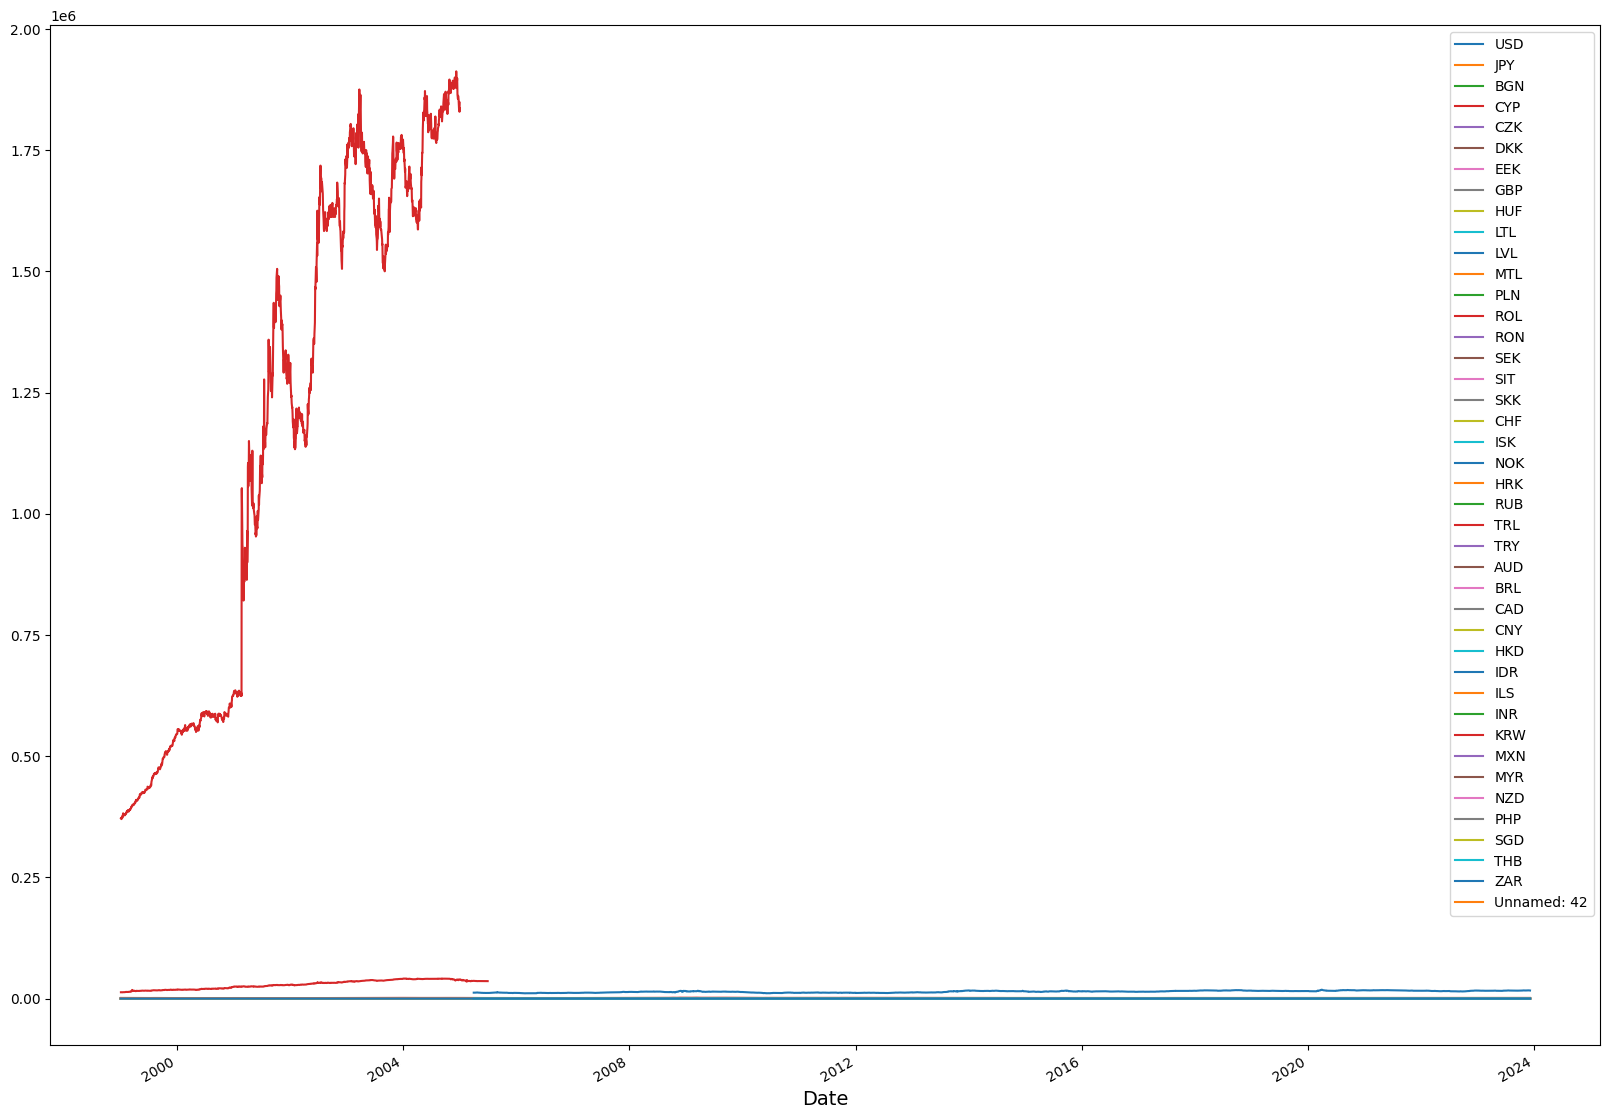

In [5]:
# Visualize the dataset
df.plot(figsize=(20, 15))

In [6]:
# Standardize the data using StandardScaler
estandar = StandardScaler()
df_est = pd.DataFrame(estandar.fit_transform(df), columns=df.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [7]:
# Transform the data for the autoencoder
X = np.array(df_est).T
X = SimpleImputer().fit_transform(X)
X = np.expand_dims(X, axis=-1)
X = np.expand_dims(X, axis=1)

In [8]:
# Define a deep convolutional autoencoder model
stride = 1
model = keras.Sequential(
    [
        layers.Input(shape=(X.shape[1], X.shape[2], X.shape[3])),
        layers.Conv2D(filters=32, kernel_size=(10, 1), padding="same", strides=stride, activation="relu"),
        layers.Conv2D(filters=64, kernel_size=(10, 1), padding="same", strides=stride, activation="relu"),
        layers.Conv2D(filters=128, kernel_size=(10, 1), padding="same", strides=stride, activation="relu"),
        layers.Conv2D(filters=128, kernel_size=(1, 3), padding="same", strides=stride, activation="relu"),
        layers.Dense(units=384, activation='relu'),
        layers.Dense(units=5, activation='relu'),
        layers.Dense(units=384, activation='relu'),
        layers.Conv2DTranspose(filters=128, kernel_size=(1, 3), padding="same", strides=stride, activation="relu"),
        layers.Conv2DTranspose(filters=128, kernel_size=(10, 1), padding="same", strides=stride, activation="relu"),
        layers.Conv2DTranspose(filters=64, kernel_size=(10, 1), padding="same", strides=stride, activation="relu"),
        layers.Conv2DTranspose(filters=32, kernel_size=(10, 1), padding="same", strides=stride, activation="relu"),
        layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), padding="same", strides=stride, activation="relu"),
    ]
)

In [9]:
# Compile the autoencoder model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 6387, 32)       352       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 6387, 64)       20544     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 6387, 128)      82048     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 6387, 128)      49280     
                                                                 
 dense (Dense)               (None, 1, 6387, 384)      49536     
                                                                 
 dense_1 (Dense)             (None, 1, 6387, 5)        1925      
                                                                 
 dense_2 (Dense)             (None, 1, 6387, 384)      2

In [10]:
# Train the autoencoder model
history = model.fit(X, X, epochs=100, batch_size=5, validation_split=0.1)

Epoch 1/100
8/8 [==============================] - 45s 5s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 2/100
8/8 [==============================] - 20s 3s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 3/100
8/8 [==============================] - 21s 3s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 4/100
8/8 [==============================] - 22s 3s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 5/100
8/8 [==============================] - 22s 3s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 6/100
8/8 [==============================] - 23s 3s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 7/100
8/8 [==============================] - 20s 3s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 8/100
8/8 [==============================] - 22s 3s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 9/100
8/8 [==============================] - 22s 3s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 10/100
8/8 [==============================] - 22s 3s/step - loss: 0.7704 - val_loss: 0.7437
Epoch 11/100
8/8 [===========

<Axes: >

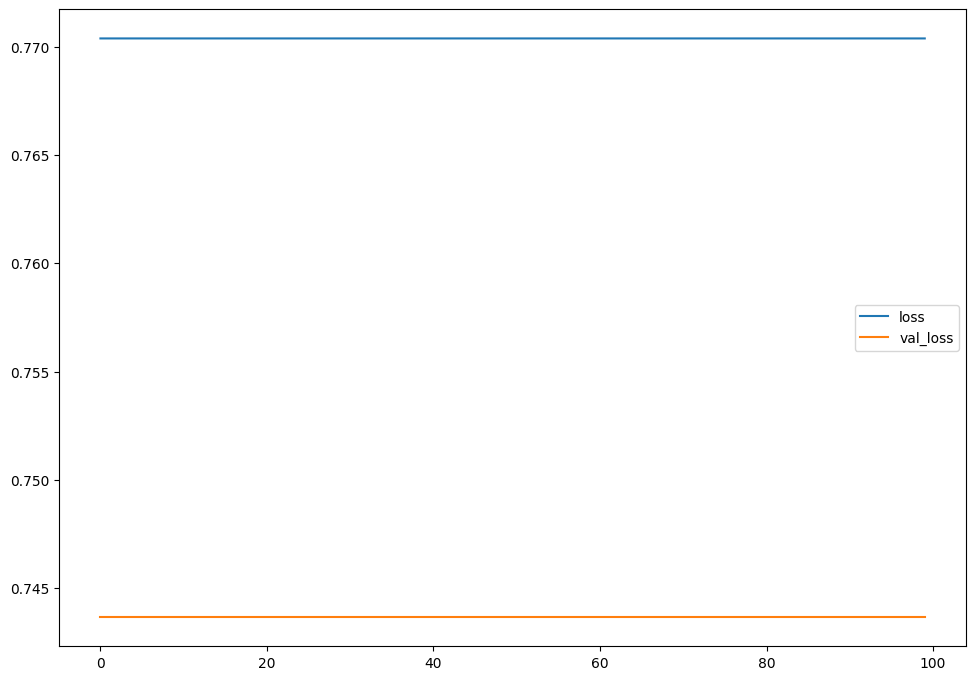

In [11]:
# Visualize the training history
pd.DataFrame(history.history).plot()

In [12]:
# Extract features from the trained autoencoder model
extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
features = extractor(X)[5]

In [13]:
# Reshape the features for further analysis
features = np.array(features[:, 0, :, :])
features = features.reshape((features.shape[0], -1))

In [14]:
# Apply PCA to the extracted features
n_clusters = 5
z = PCA().fit_transform(features)

In [15]:
# Apply KMeans clustering to the PCA-transformed features
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(z)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


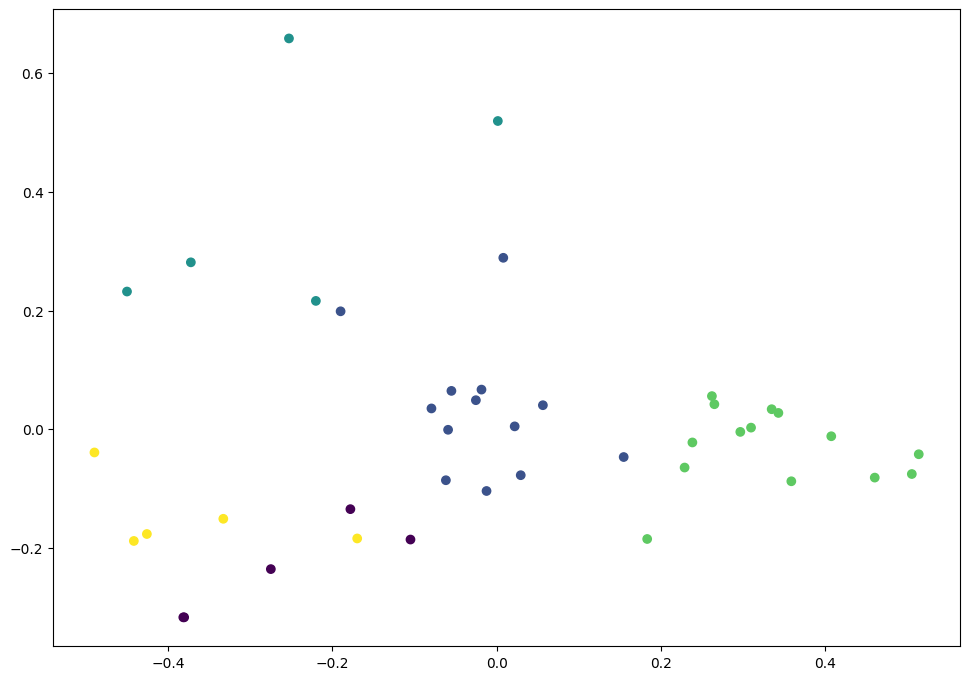

In [16]:
# Visualize the results of clustering
plt.scatter(z[:, 0], z[:, 1], c=kmeans.labels_)

In [17]:
# Visualize the series for each cluster
clusters = kmeans.labels_
series = df.columns

for cluster in np.unique(clusters):
    print(f"Cluster {cluster}:")
    print(list(series[clusters == cluster]))

Cluster 0:
['USD', 'LVL', 'HKD', 'ILS', 'KRW']
Cluster 1:
['BGN', 'CYP', 'DKK', 'EEK', 'MTL', 'ROL', 'SIT', 'SKK', 'HRK', 'TRL', 'CAD', 'MYR', 'Unnamed: 42']
Cluster 2:
['CZK', 'LTL', 'CHF', 'AUD', 'NZD']
Cluster 3:
['GBP', 'HUF', 'PLN', 'RON', 'SEK', 'ISK', 'NOK', 'RUB', 'TRY', 'BRL', 'IDR', 'INR', 'MXN', 'ZAR']
Cluster 4:
['JPY', 'CNY', 'PHP', 'SGD', 'THB']


Cluster:  0


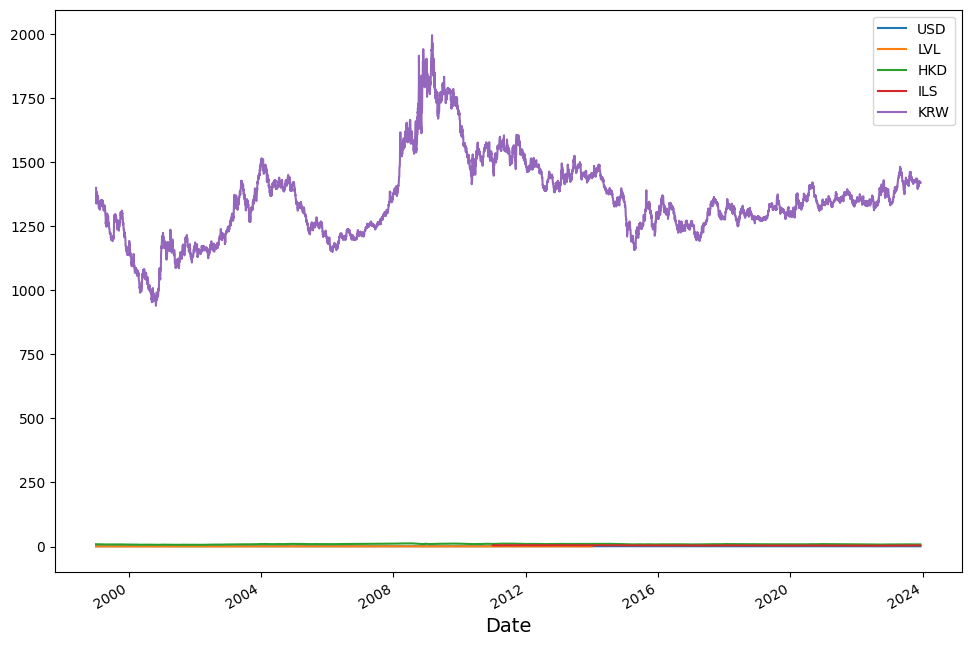

Cluster:  1


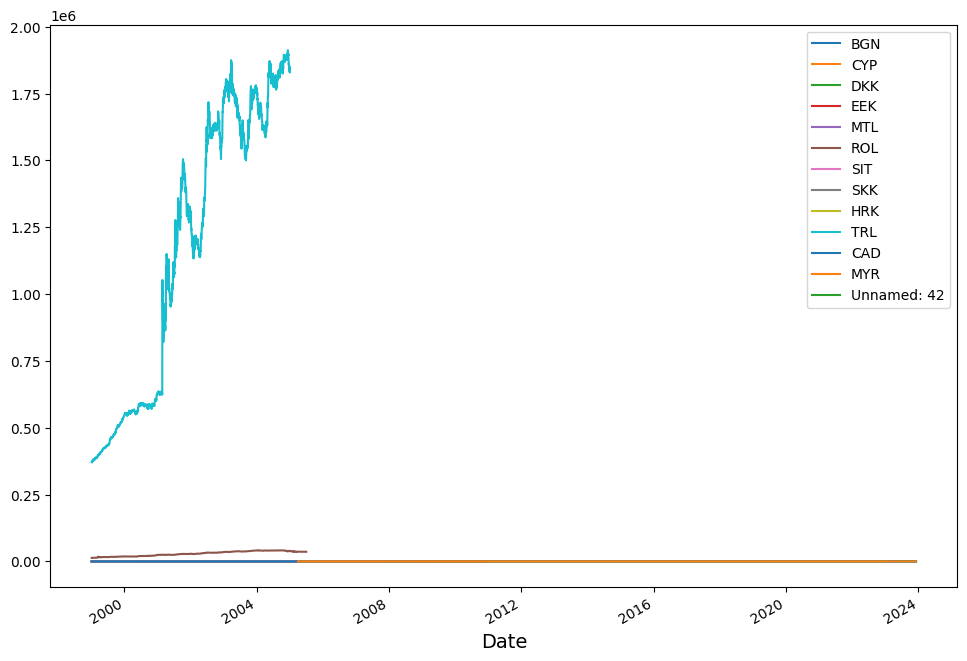

Cluster:  2


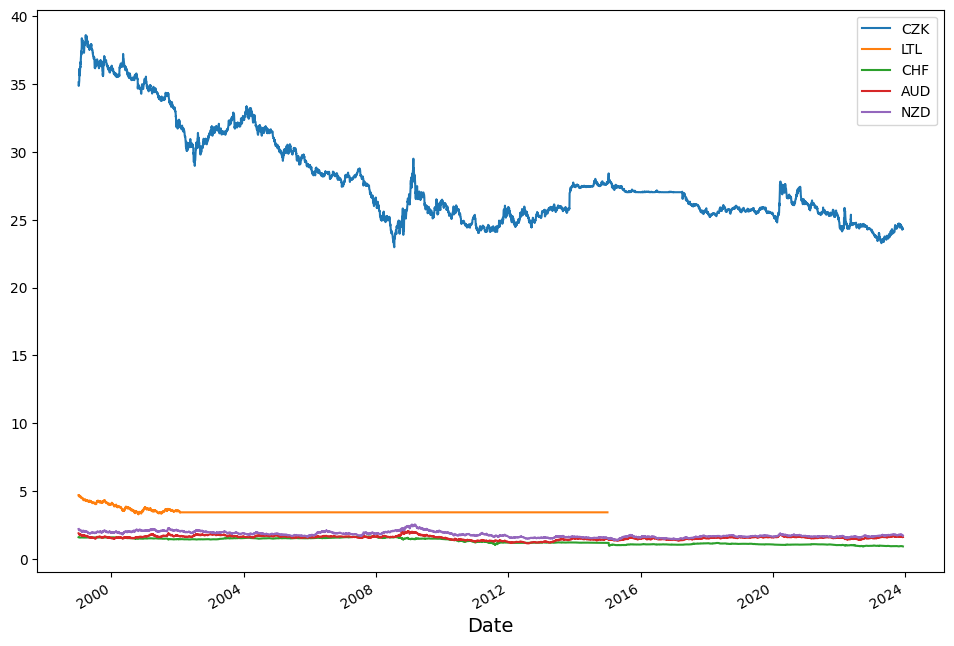

Cluster:  3


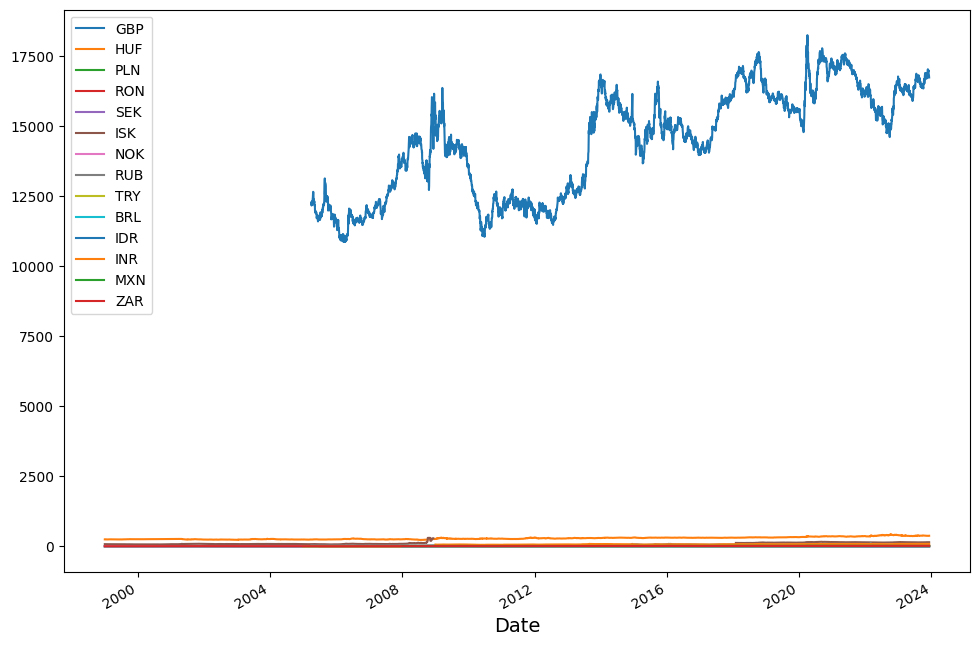

Cluster:  4


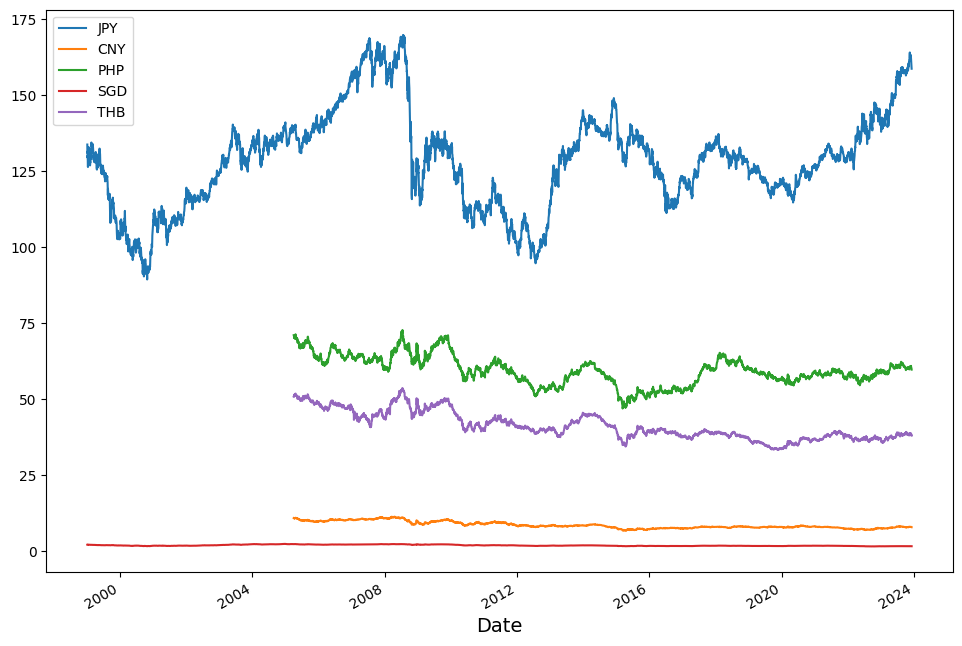

In [21]:
# Visualize time series for each cluster
colors = list(mcolors.TABLEAU_COLORS.keys())
line_colors = []

for color in kmeans.labels_:
    line_colors.append(colors[color])

for cluster in np.unique(clusters):
    columns = series[clusters == cluster]
    print("Cluster: ", cluster)
    df[columns].plot()
    plt.show()

In [22]:
#Anomaly detection

# Choose a specific currency column for analysis (e.g., 'USD')
selected_currency = 'USD'

In [23]:
# Extract the selected currency column and handle missing values with interpolation
df_selected = df[[selected_currency]].interpolate(method="time")

In [24]:
# Remove trend using STL algorithm
stl = STL(df_selected[selected_currency], period=24)
res = stl.fit()
df_detrended = df_selected - res.trend.values.reshape(-1, 1)

In [25]:
# Scale the data for the autoencoder
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_detrended)

In [26]:
# Split the data into training and testing sets
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

In [28]:
# Define the autoencoder model
input_layer = Input(shape=(1,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(1, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [74]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100
160/160 [==============================] - 1s 6ms/step - loss: 6.9281e-07 - val_loss: 8.7515e-06
Epoch 2/100
160/160 [==============================] - 1s 5ms/step - loss: 3.2964e-05 - val_loss: 4.6840e-06
Epoch 3/100
160/160 [==============================] - 1s 8ms/step - loss: 2.6857e-06 - val_loss: 6.4791e-07
Epoch 4/100
160/160 [==============================] - 1s 8ms/step - loss: 3.9647e-06 - val_loss: 5.8231e-07
Epoch 5/100
160/160 [==============================] - 2s 16ms/step - loss: 1.1130e-06 - val_loss: 3.4372e-07
Epoch 6/100
160/160 [==============================] - 0s 3ms/step - loss: 7.0857e-09 - val_loss: 3.7669e-07
Epoch 7/100
160/160 [==============================] - 0s 3ms/step - loss: 5.8440e-09 - val_loss: 3.9762e-07
Epoch 8/100
160/160 [==============================] - 0s 3ms/step - loss: 9.3750e-09 - val_loss: 4.5763e-07
Epoch 9/100
160/160 [==============================] - 0s 3ms/step - loss: 1.0598e-07 - val_loss: 4.0530e-07
Epoch 10/100
160/1

In [75]:
# Reconstruct the data using the trained autoencoder
df_reconstructed = pd.DataFrame(autoencoder.predict(df_scaled), columns=[selected_currency])
df_reconstructed.index = df_detrended.index

200/200 [==============================] - 0s 2ms/step


In [76]:
# Calculate the reconstruction error
reconstruction_error = ((df_scaled - autoencoder.predict(df_scaled)) ** 2).mean(axis=1)

200/200 [==============================] - 0s 1ms/step


In [77]:
# Set a threshold for anomaly detection
threshold = reconstruction_error.mean() + 2.5 * reconstruction_error.std()

In [78]:
# Mark anomalies
df_detrended['autoencoder_anomaly'] = reconstruction_error > threshold

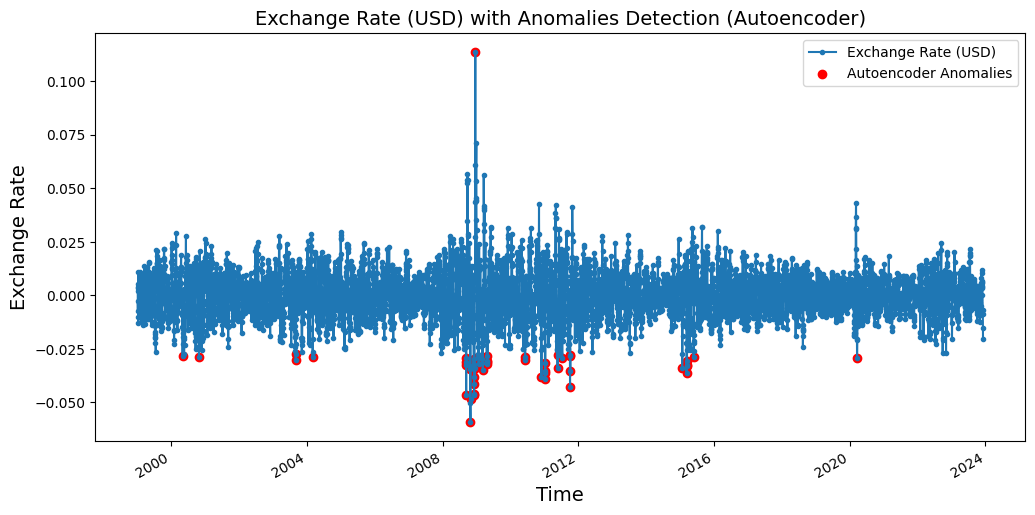

In [79]:
# Plot the series with autoencoder anomalies
plt.figure(figsize=[12, 6])
df_detrended[selected_currency].plot(style='.-', label=f'Exchange Rate ({selected_currency})')
plt.scatter(df_detrended[df_detrended['autoencoder_anomaly']].index,
            df_detrended[df_detrended['autoencoder_anomaly']][selected_currency],
            color='red',
            label='Autoencoder Anomalies')

# Add labels and title
plt.title(f"Exchange Rate ({selected_currency}) with Anomalies Detection (Autoencoder)")
plt.ylabel("Exchange Rate")
plt.xlabel("Time")
plt.legend()
plt.show()